In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Data Preprocessing


In [10]:
# Download the CIFAR-10 dataset
!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!mkdir cifar-10
!tar -xzvf cifar-10-python.tar.gz -C cifar-10/

--2024-01-02 13:14:05--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  99.2MB/s    in 1.6s    

2024-01-02 13:14:07 (99.2 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


Importing the necessary libraries


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [33]:
transform = transforms.Compose( # composing several transforms together
    [transforms.ToTensor(), # to tensor object
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean = 0.5, std = 0.5

batch_size = 4
num_workers = 0
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

# load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

# put 10 classes into a set
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


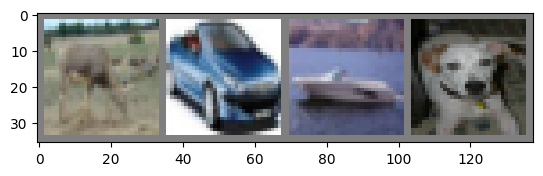

deer car ship dog


In [27]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get random training images with iter function
dataiter = iter(trainloader)
images, labels = next(dataiter)

# call function on our images
imshow(torchvision.utils.make_grid(images))

# print the class of the image
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))


In [24]:
class Net(nn.Module):
    ''' Models a simple Convolutional Neural Network'''

    def __init__(self):

        super(Net, self).__init__()
	# 3 input image channel, 6 output channels,
	# 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
	# Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)# 5x5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()
print(Net)


<class '__main__.Net'>


In [30]:
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss is used as it combines LogSoftmax and NLLLoss
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [34]:
# Training the model
num_epochs = 5 # Adjust as needed

model.train()

for epoch in range(num_epochs):
    for inputs, targets in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

In [35]:
print("Finished Training")

Finished Training


In [46]:
# Switch model to evaluation mode
model.eval()

# Initialize variables to track performance
total_samples = 0
correct_predictions = 0

# Disable gradient computations
with torch.no_grad():
    for inputs, targets in testloader:
        outputs = model(inputs)

        # Get the predicted class (the one with the highest probability)
        _, predicted = torch.max(outputs.data, 1)

        # Update total and correct counts
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()

# Calculate accuracy
accuracy = 100 * correct_predictions / total_samples
print(f'Accuracy of the model on the test data: {accuracy:.2f}%')

Accuracy of the model on the test data: 58.60%


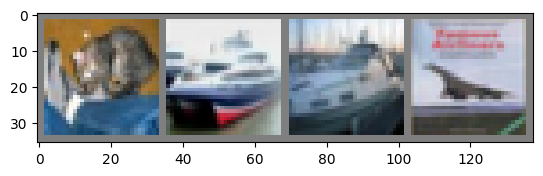

GroundTruth:  cat ship ship plane


In [47]:

dataiter = iter(testloader)
images, labels =next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(4)))

In [48]:
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  cat ship ship plane


In [44]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 58 %
